# Deutsch-Jozsaのアルゴリズム

## アルゴリズムの概要
Deutsch-Jozsaのアルゴリズムは、入力変数$\{x_0, ... x_{n-1}\} (x_i \in \{0, 1\})$をもつ関数$f(x)$が定数関数かバランス関数かを1回で判定することができるアルゴリズムです。

まず、関数$f(x)$を実現するオラクルを作成します。

1. 定値関数の場合<br>
入力変数$x$をレジスター1,位相キックバックのためのビットをレジスタ―２だとすると、

    1. f(x) = 0の場合、レジスター2の量子ビットに I ゲートを適用します。
    2. f(x) = 1の場合、レジスター2の量子ビットに Xゲートを適用します。

2. バランス関数の場合<br>
例えば、レジスター1の各量子ビットを制御ビットで、レジスター2の量子ビットをターゲットにしてCNOTを実行することで、回路が分布型であることを保証できます。

In [1]:
from qiskit import QuantumCircuit, QuantumRegister

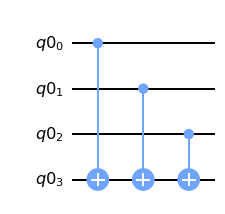

In [2]:
q = QuantumRegister(4)
qc = QuantumCircuit(q)

for i in range(3):
    qc.cx(i, 3)

qc.draw(output="mpl")

制御ビットをXゲートでラップすることにより、分布型であることを保ちながら結果を変更できます。最初の簡単な実装では、Xゲートを上記のゲートに追加した$3^2=8$パターンの回路をランダムに構成します。

オラクルを作成します。

In [3]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)

    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    if case == "balanced":
        #Xゲートのためのバイナリ列を用意
        b = np.random.randint(1, 2**n)
        b_str = format(b, "0="+str(n)+"b")

        for qubit in range(len(b_str)):
            if b_str[qubit] == "1":
                oracle_qc.x(qubit)

        for qubit in range(n):
            oracle_qc.cx(qubit, n)

        for qubit in range(len(b_str)):
            if b_str[qubit] == "1":
                oracle_qc.x(qubit)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "dj_oracle"
    return oracle_gate

In [4]:
def dj_algo(oracle, n):
    dj_qc = QuantumCircuit(n+1, n)

    dj_qc.x(n)
    dj_qc.barrier()
    
    for qubit in range(n+1):
        dj_qc.h(qubit)
    
    dj_qc.append(oracle, range(n+1))

    for qubit in range(n):
        dj_qc.h(qubit)
        dj_qc.measure(qubit, qubit)

    return dj_qc

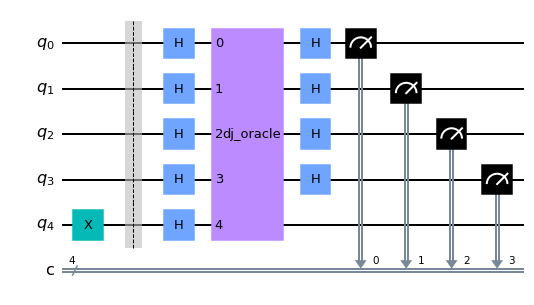

In [6]:
import numpy as np
n = 4
oracle_gate = dj_oracle("balanced", n)
dj_circuit = dj_algo(oracle_gate, n)
dj_circuit.draw(output="mpl")

In [7]:
from qiskit import Aer, execute
def get_count(qc, back_end="qasm_simulator", shots = 1024):
    back_end = Aer.get_backend(back_end)
    results = execute(qc, backend=back_end, shots=shots).result()
    count_num = results.get_counts()
    return count_num

{'1111': 1024}


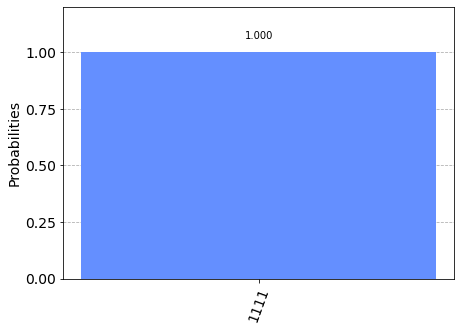

In [8]:
from qiskit.visualization import plot_histogram
count_num = get_count(dj_circuit)
print(count_num)
plot_histogram(count_num)

バランス型関数の組み合わせは、xがnbitであるとき${}_{2^n}C_{2^{n-1}}$通りありますが、このバランス型オラクルの作成については[YouTube](https://www.youtube.com/watch?v=vHIag48qFMA)を見てから考えます。